# 一 关于泰坦尼克号

    对于泰坦尼克号的认知，首相想到的是电影，不过我一直都没有补过电影，比较可惜。对于一次灾难性的事故，其中的数据是值得分析，同时也有很多疑问，也许能从数据中找到答案。我觉得在灾难中生存下来主要的因素是运气，除了运气之前还有哪些？
    1 身份和地位是否能拯救自己的生命？
    2 妇女儿童是否会被优先拯救？
    3 什么年纪的乘客生存率最高？

# 二 数据集及处理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filename = 'titanic-data.csv'
titanic_df = pd.read_csv(filename)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


```
数据集包括了891名人员的信息，数据字典为：
Variable    Definition	                                     
survival: Survival（幸存与否）	       0 = No, 1 = Yes                         
pclass: Ticket class(船票级别，反应身份地位)
Ticket: class（船舱级别）                           
name: （名字）
sex: （性别）
Age: （年龄）
sibsp: （兄弟姐妹和配偶的数量）
parch: （父母及子女的数量）	
ticket: Ticket number（船票号）	
fare: Passenger fare（票价）	
cabin: 	Cabin number（船舱位）	
embarked: Port of Embarkation（上船的港口）	 C = Cherbourg, Q = Queenstown, S = Southampton
```
    首先清理数据，按照我想了解的3个问题，那么我需要保留的字段是：'Survived', 'Pclass', 'Sex', 'Age'这四个字段的信息。

In [2]:
titanic_tmp_df = titanic_df[['Survived', 'Pclass', 'Sex', 'Age']]
titanic_tmp_df.describe()

,Survived,Pclass,Age
count,891.000000,891.000000,714.000000
mean,0.383838,2.308642,29.699118
std,0.486592,0.836071,14.526497
min,0.000000,1.000000,0.420000
25%,0.000000,2.000000,20.125000
50%,0.000000,3.000000,28.000000
75%,1.000000,3.000000,38.000000
max,1.000000,3.000000,80.000000


    这里发现age字段应该有数据是为空值的，需要把空值的数据清理掉，对剩余的714条数据进行分析。

In [3]:
titanic = titanic_tmp_df[titanic_tmp_df["Age"].notnull()]
print len(titanic)
print titanic.head()

714
   Survived  Pclass     Sex   Age
0         0       3    male  22.0
1         1       1  female  38.0
2         1       3  female  26.0
3         1       1  female  35.0
4         0       3    male  35.0


    #审阅建议：
    #报告中对数据进行了些变更，比如生成新的child变量等。这些变更与数据的分析环节夹杂在一起。
    #建议在分析环节前新建一个数据清理环节，将所有对数据的变更操作放入这个环节中。数据处理干净后再将干净的数据放入分析环节开始分析。
    #一般数据分析的步骤为：介绍背景及提出问题 --> 数据处理 --> 数据分析 —> 结论和限制.
    
    因为我需要对妇女儿童数据进行分析，故需在此阶段为数据添加一个字段并判断乘客信息是否为儿童。

In [4]:
def is_child(age):
    if age < 18:
        return 1
    else:
        return 0

titanic['Child'] = pd.Series(titanic['Age'].apply(is_child))
print titanic.head()

   Survived  Pclass     Sex   Age  Child
0         0       3    male  22.0      0
1         1       1  female  38.0      0
2         1       3  female  26.0      0
3         1       1  female  35.0      0
4         0       3    male  35.0      0


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


    审阅建议：
    最后一个问题“哪个年龄区间的生还率最高” 并没有完成。我们要分析的是哪个年龄段的存活率高，而不是哪个年龄段存活的人数最多。
    存活人数多并不代表存活率高，比如A年龄段存活100人，但是人口有1000个，B年龄段存活10人，人口20个，哪个存活率高呢？很明显是A。
    因此我们需要对其计算存活率。这里提示一下age变量的分析：对于age变量的分析，因为年龄变量为连续变量，与pclass这种分类变量相比分析难度较高。
    这里我们的想法是将连续变量转化成分类变量。我们可以新建一个年龄段变量，比如(0, 10], (10, 20]......然后对乘客根据年龄分组。
    这样就可以对每一个组像其他几个变量一样计算其存活率啦！
    
    为了对年龄进行分析，需要添加一个新字段Age_range来记录年龄的分组。

In [5]:
def group_age(age, n = 10):
    return '[%d ,%d)' % (n * (age//n) , n * (age//n) + n)
    '''
    switcher = {(0.0 < age <= 10.0):'(0, 10]', (10.0 < age <= 20.0):'(10, 20]'}
    if 0.0 < age <= 10.0:
        return '(0, 10]'
    if 10.0 < age <= 20.0:
        return '(10, 20]'
    if 20.0 < age <= 30.0:
        return '(20, 30]'
    if 30.0 < age <= 40.0:
        return '(30, 40]'
    if 40.0 < age <= 50.0:
        return '(40, 50]'
    if 50.0 < age <= 60.0:
        return '(50, 60]'
    if 60.0 < age <= 70.0:
        return '(60, 70]'
    if 70.0 < age <= 80.0:
        return '(70, 80]'
    if 80.0 < age <= 90.0:
        return '(80, 90]'
    if 90.0 < age <= 100.0:
        return '(90, 100]'
    else:
        return '(100, -]'
    '''

In [6]:
titanic['Age_range'] = pd.Series(titanic['Age'].apply(group_age))
print titanic.head()

   Survived  Pclass     Sex   Age  Child Age_range
0         0       3    male  22.0      0  [20 ,30)
1         1       1  female  38.0      0  [30 ,40)
2         1       3  female  26.0      0  [20 ,30)
3         1       1  female  35.0      0  [30 ,40)
4         0       3    male  35.0      0  [30 ,40)


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


# 三 数据分析

    #审阅建议：
    #报告中的分析只进行了存活率计算，而没有计算各个群体的人口数目，这样是有误的。因为采用存活率=该群体存活人口数／该群体数量，单单这个除法的计算而没有观察分母的大小(样本数量)的话这个计算并没有意义。比如说女性存活率计算得出100%，但是如果女性总共只有1个人的话，这个所计算出来的存活率100%可信吗？显然不可以的，因为样本数量太少。所以我们需要对每个计算了存活率的变量计算人口数量分布并且用图形来可视化。

In [7]:
def survived_rate_with(index):
    group = titanic[['Survived', index]].groupby(index)
    #print group.sum()  #生还人数组
    print 'Number of members in ' + index + ' group'
    print group.count()  #总人数组
    #group_number = group.count()
    survived_rate = group.sum() / group.count()
    #print survived_rate
    #return survived_rate
    survived_rate.plot(kind = 'bar')
    group.count().plot(kind = 'pie', subplots=True, autopct = '%.0f%%')
    plt.xlabel(index)
    plt.ylabel('Survived_rate')
    plt.show()

Number of members in Pclass group
        Survived
Pclass          
1            186
2            173
3            355


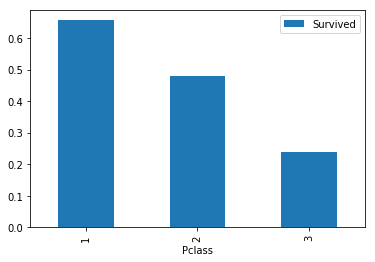

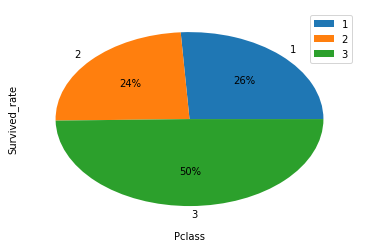

In [8]:
survived_rate_with('Pclass') 
#.plot(kind = 'bar')
#plt.xlabel('Ticket class')
#plt.ylabel('Survived_rate')
#plt.show()

    从上表可以看出，社会地位高或富有的人的生存率更高。是1级和2级仓位在船后或者在上层的甲板么？

Number of members in Child group
       Survived
Child          
0           601
1           113


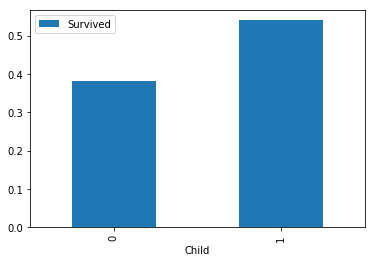

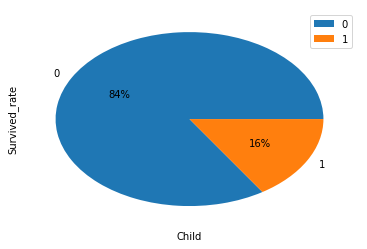

In [9]:
survived_rate_with('Child')
#.plot(kind = 'bar')
#plt.xlabel('Is child')
#plt.ylabel('Survived_rate')
#plt.show()

Number of members in Sex group
        Survived
Sex             
female       261
male         453


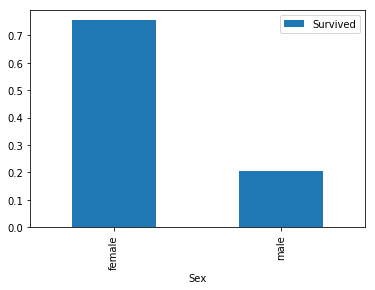

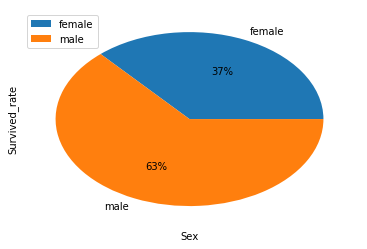

In [10]:
survived_rate_with('Sex')
#.plot(kind = 'bar')
#plt.xlabel('Sex')
#plt.ylabel('Survived_rate')
#plt.show()

    从上数据及图表可以看出，妇女儿童得到了优先的救护；并且生还率均高于50%。

    下面我要分析哪个年龄区间的生还率最高。

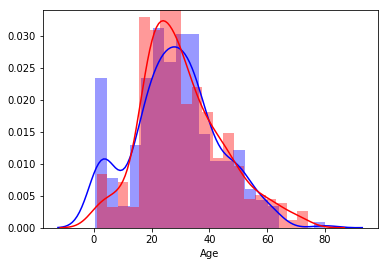

In [11]:
import seaborn as sns

survived_age = titanic[titanic['Survived'] == 1]['Age']
#print survived_age.head()
not_survived_age = titanic[titanic['Survived'] == 0]['Age']

ax = sns.distplot(survived_age, bins=20, color='blue')
#g = sns.pairplot(titanic) 
ax2 = sns.distplot(not_survived_age, bins=20, color='red')

    从上图大概可以看出，生还者和非生还者的年龄段都集中在16~40岁，这很难得出结论，所以我们需要对年龄进行分段处理，来计算其存活率。

Number of members in Age_range group
           Survived
Age_range          
[0 ,10)          62
[10 ,20)        102
[20 ,30)        220
[30 ,40)        167
[40 ,50)         89
[50 ,60)         48
[60 ,70)         19
[70 ,80)          6
[80 ,90)          1


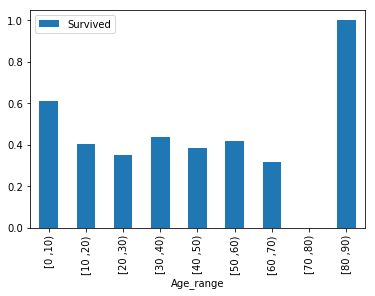

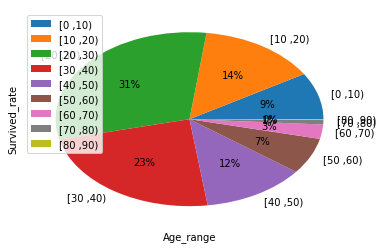

In [12]:
survived_rate_with('Age_range') 

    从上图数据可以看出，生存率最高的是0~10岁的少年及婴儿，其次是30~40岁的青壮年和50~60岁的分组，80~90岁组因样本只有1人，我觉得应该排除在外或者作为特例。

# 四 结论
    泰坦尼克号上乘客约有1317人，但是数据样本仅有891人，在数据处理过程中除去清理过的数据内容，使用了714人的数据来进行分析，故无法保证全面；就目前分析情况，妇女和儿童会得到优先的救援，并且在一二等舱的乘客的死亡率更低，并且生还者的年龄除了婴幼儿和少年，其次是30~40岁的青壮年和50~60岁的分组。另外由于事故发生时间是夜晚，我认为船舱位置是否靠近救生艇，并且船舱位置是否处于甲板前中段也会对生还率造成影响，但是船舱区域划分及位置数据太少，难以分析。

    参考的文章：
    https://blog.csdn.net/suzyu12345/article/details/69029106
    http://tieba.baidu.com/p/3914410460?see_lz=1
    https://zh.wikipedia.org/wiki/%E6%B3%B0%E5%9D%A6%E5%B0%BC%E5%85%8B%E5%8F%B7
    age_range函数参考了这篇文章中的年龄算法 https://blog.csdn.net/hewb14/article/details/50520524 